<a href="https://colab.research.google.com/github/ravitejameka/ravitejameka/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# **DATA EXTRACTION**

In [48]:
c = pd.read_csv('/content/Customers.csv')
s = pd.read_csv('/content/Subscription.csv')
t = pd.read_csv('/content/Transcation.csv')
u = pd.read_csv('/content/usage.csv')

# **DATA EXTRACTION AND TRANSFORMATION**

In [49]:
m = pd.merge(c,s,on='CustomerID', how='left')
m = m.merge(t,on='CustomerID', how='left')
m = m.merge(u,on='CustomerID', how='left')

In [50]:
m.head()

,CustomerID,Name,Age,Gender,Income,Location,SubscriptionID,StartDate,EndDate,Status,transaction_id,transaction_date,amount,transaction_type,usage_id,feature_used,usage_date,usage_amount
0,1,Karan Reddy,29,Male,40000,Hyderabad,SUB0001,2022-01-31,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Anaya Joshi,35,Female,55000,Bangalore,SUB0002,2022-02-28,2024-11-21,No,e183937c,2024-10-01,13.92,Debit,NaN,NaN,NaN,NaN
2,3,Diya Das,28,Female,60000,Chennai,SUB0003,2022-03-31,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Siddharth Reddy,32,Male,45000,Delhi,SUB0004,2022-04-30,2024-11-21,No,ce657026,2024-06-05,17.95,Debit,NaN,NaN,NaN,NaN
4,4,Siddharth Reddy,32,Male,45000,Delhi,SUB0004,2022-04-30,2024-11-21,No,46f2aa8f,2024-07-29,15.75,Credit,NaN,NaN,NaN,NaN


In [51]:
m['StartDate'] = pd.to_datetime(m['StartDate'])
m['EndDate'] = pd.to_datetime(m['EndDate'])
m['transaction_date'] = pd.to_datetime(m['transaction_date'])

In [52]:
m['tenure_days'] = (m['EndDate'] - m['StartDate']).dt.days
m['is_churned'] = m['Status'].apply(lambda x: 1 if x == 'churned' else 0)
m['monthly_spend'] = m['amount'] / (m['tenure_days'] / 30).clip(lower=1)

In [53]:
m.fillna({'monthly_spend': 0, 'usage_amount': 0}, inplace=True)


# **EXPLORATORY DATA ANALYSIS**

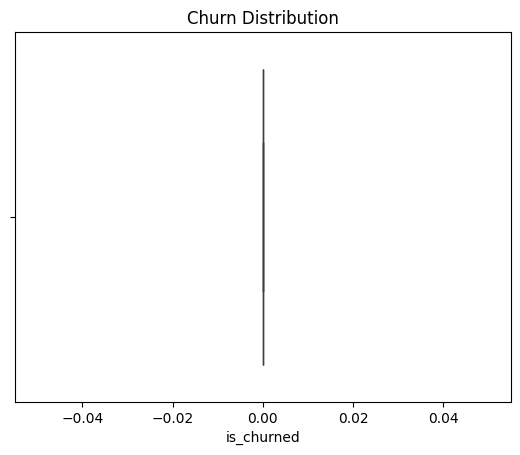

In [78]:
sb.boxplot(x='is_churned', data=m)
plt.title('Churn Distribution')
plt.show()


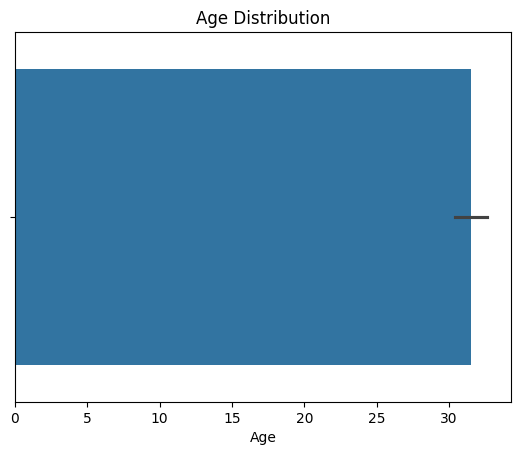

In [75]:
sb.barplot(x=m['Age'])
plt.title('Age Distribution')
plt.show()

array([<Axes: title={'center': 'Age'}, xlabel='Gender'>,
       <Axes: title={'center': 'Income'}, xlabel='Gender'>], dtype=object)

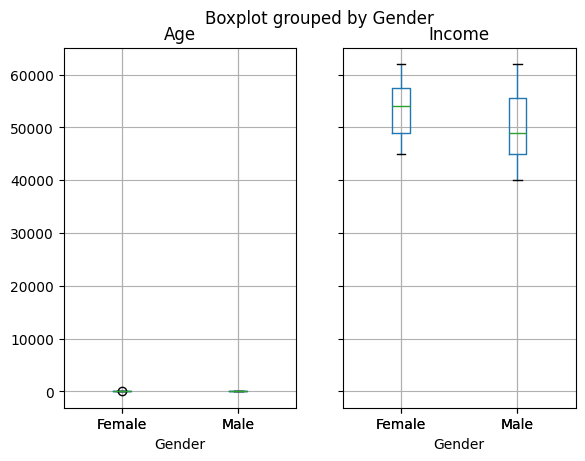

In [77]:
m.boxplot(by='Gender', column=['Age','Income'])

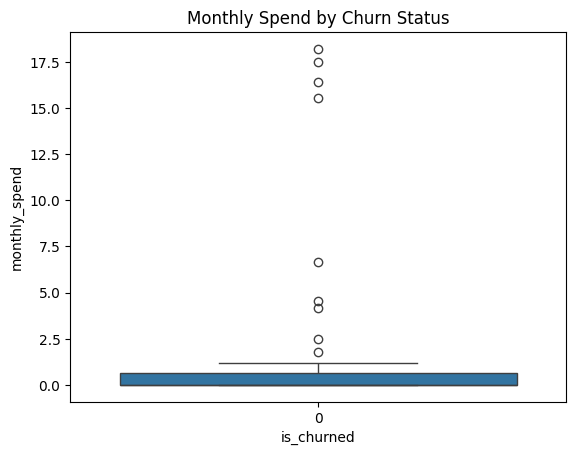

In [57]:
sb.boxplot(x='is_churned', y='monthly_spend', data=m)
plt.title('Monthly Spend by Churn Status')
plt.show()

# **CHUN PREDICTION**

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

features = ['Age', 'Income','tenure_days', 'monthly_spend', 'usage_amount']
X = m[features]
y = m['is_churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



# **CUSTOMER SEGMENTATION**

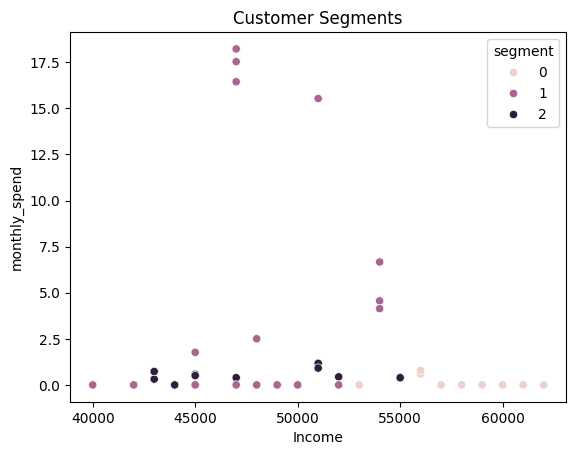

In [67]:

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
X = m[features]
X = imputer.fit_transform(X)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X) # Use the imputed data here

kmeans = KMeans(n_clusters=3, random_state=42)
m['segment'] = kmeans.fit_predict(scaled_features)

sb.scatterplot(x='Income', y='monthly_spend', hue='segment', data=m) # Note: 'income' should be 'Income'
plt.title('Customer Segments')
plt.show()

# **REVENUE FORCASTING**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa5u1yblw/3pw49eww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa5u1yblw/rz97yz5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8857', 'data', 'file=/tmp/tmpa5u1yblw/3pw49eww.json', 'init=/tmp/tmpa5u1yblw/rz97yz5h.json', 'output', 'file=/tmp/tmpa5u1yblw/prophet_modelb7x33_dy/prophet_model-20241123152808.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:28:08 - cmdstanpy - INFO - Chain [1] start processing
INF

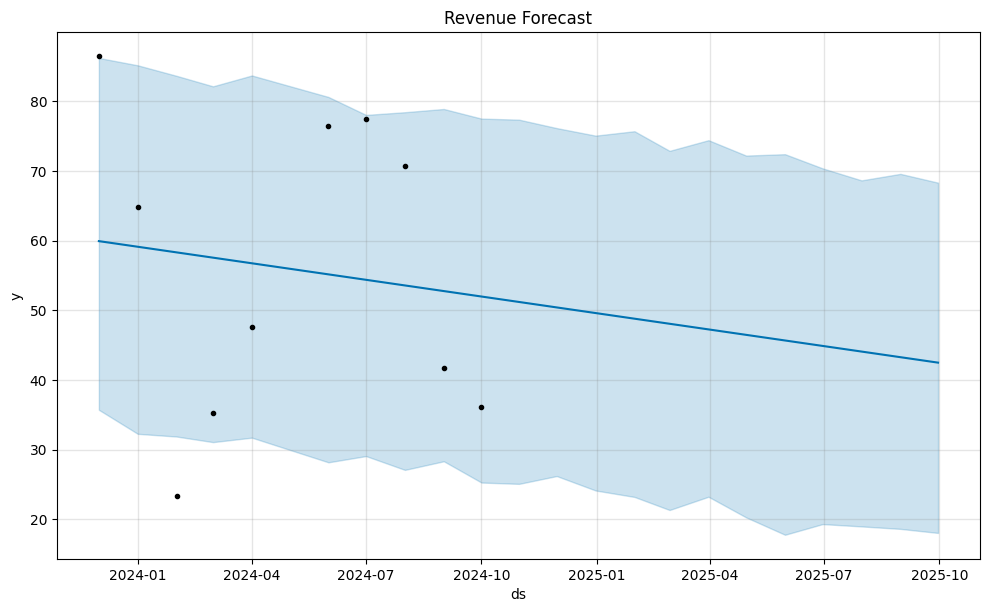

In [66]:

from prophet import Prophet

m['transaction_month'] = pd.to_datetime(m['transaction_date']).dt.to_period('M').dt.to_timestamp() # Convert to datetime
monthly_revenue = m.groupby('transaction_month')['amount'].sum().reset_index()
monthly_revenue.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(monthly_revenue)

future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title('Revenue Forecast')
plt.show()

# **REPORTING AND INSIGHTS**

In [65]:
output_data = {
    'Churn Predictions': pd.DataFrame({'Churn Prediction': y_pred}),
    'Customer Segments': m[['CustomerID', 'segment']],
    'Revenue Forecast': forecast[['ds', 'yhat']]
}





In [64]:
output_data["Revenue Forecast"].to_csv("revenue_forcaste.csv", index = False)
output_data['Churn Predictions'].to_csv("churn_prediction.csv", index=False)
output_data['Customer Segments'].to_csv("customer_segments.csv", index = False)